In [9]:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import numpy as np


Chuẩn bị dữ liệu FashionMNIST

In [10]:
# Các phép biến đổi: ToTensor và Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Tải bộ dữ liệu huấn luyện và kiểm tra
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 171kB/s]


Xây dựng mạng thần kinh

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Khởi tạo mô hình
model = NeuralNetwork()

Định nghĩa hàm mất mát, bộ tối ưu hóa và thiết bị

In [12]:
criterion = nn.CrossEntropyLoss() # Hàm mất mát CrossEntropy
optimizer = optim.Adam(model.parameters(), lr=0.001) # Bộ tối ưu hóa Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Chọn thiết bị (GPU/CPU)
model.to(device) # Chuyển mô hình sang thiết bị

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Vòng lặp huấn luyện và đánh giá

In [13]:
num_epochs = 10
train_losses = []
test_accuracies = []

print("Bắt đầu huấn luyện mô hình...")
for epoch in range(num_epochs):
    model.train() # Chế độ huấn luyện
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Mất mát huấn luyện: {epoch_loss:.4f}")

    # Đánh giá độ chính xác
    model.eval() # Chế độ đánh giá
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Độ chính xác trên bộ kiểm tra: {accuracy:.2f}%")
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình...
Epoch 1/10, Mất mát huấn luyện: 0.4985
Độ chính xác trên bộ kiểm tra: 84.30%
Epoch 2/10, Mất mát huấn luyện: 0.3723
Độ chính xác trên bộ kiểm tra: 86.02%
Epoch 3/10, Mất mát huấn luyện: 0.3328
Độ chính xác trên bộ kiểm tra: 86.54%
Epoch 4/10, Mất mát huấn luyện: 0.3061
Độ chính xác trên bộ kiểm tra: 86.40%
Epoch 5/10, Mất mát huấn luyện: 0.2885
Độ chính xác trên bộ kiểm tra: 87.29%
Epoch 6/10, Mất mát huấn luyện: 0.2731
Độ chính xác trên bộ kiểm tra: 87.82%
Epoch 7/10, Mất mát huấn luyện: 0.2563
Độ chính xác trên bộ kiểm tra: 87.79%
Epoch 8/10, Mất mát huấn luyện: 0.2439
Độ chính xác trên bộ kiểm tra: 87.85%
Epoch 9/10, Mất mát huấn luyện: 0.2311
Độ chính xác trên bộ kiểm tra: 88.79%
Epoch 10/10, Mất mát huấn luyện: 0.2239
Độ chính xác trên bộ kiểm tra: 88.80%
Huấn luyện hoàn tất!


Lưu và tải mô hình

In [14]:
model_path = 'fashion_mnist_model.pth'
torch.save(model.state_dict(), model_path) # Lưu mô hình
print(f"Mô hình đã được lưu tại {model_path}")

loaded_model = NeuralNetwork()
loaded_model.load_state_dict(torch.load(model_path)) # Tải mô hình
loaded_model.to(device)
loaded_model.eval()
print("Mô hình đã được tải lại thành công.")

# Kiểm tra độ chính xác của mô hình đã tải lại
correct_loaded = 0
total_loaded = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_loaded += labels.size(0)
        correct_loaded += (predicted == labels).sum().item()
accuracy_loaded = 100 * correct_loaded / total_loaded
print(f"Độ chính xác của mô hình đã tải lại: {accuracy_loaded:.2f}%")

Mô hình đã được lưu tại fashion_mnist_model.pth
Mô hình đã được tải lại thành công.
Độ chính xác của mô hình đã tải lại: 88.80%


Trực quan hóa mất mát và độ chính xác

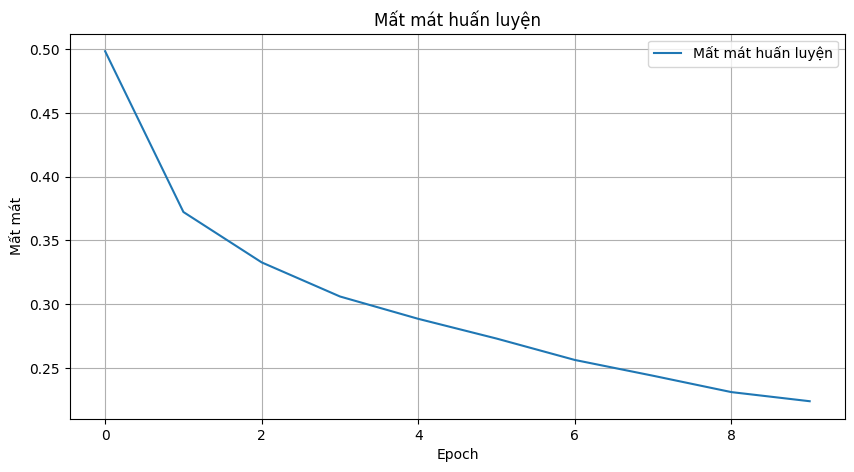

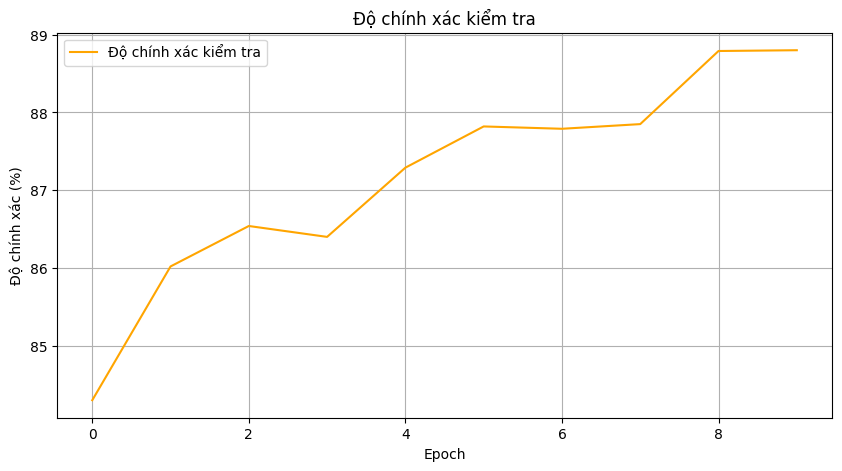

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Mất mát huấn luyện')
plt.title('Mất mát huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Độ chính xác kiểm tra', color='orange')
plt.title('Độ chính xác kiểm tra')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác (%)')
plt.legend()
plt.grid(True)
plt.show()

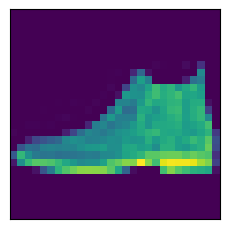

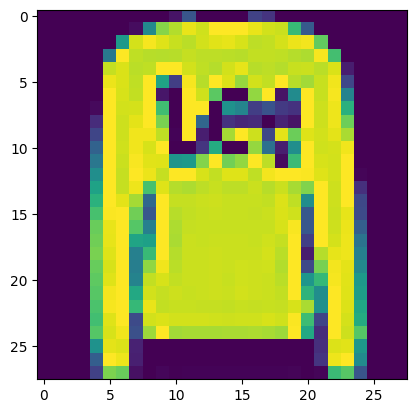

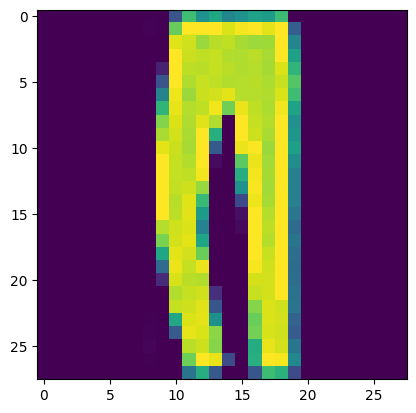

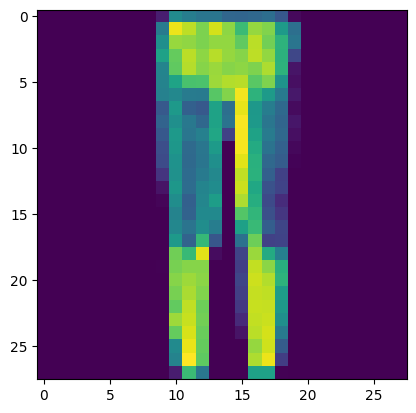

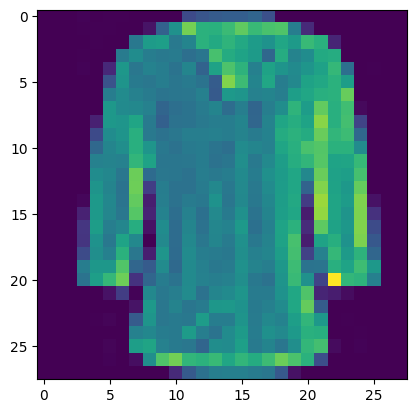

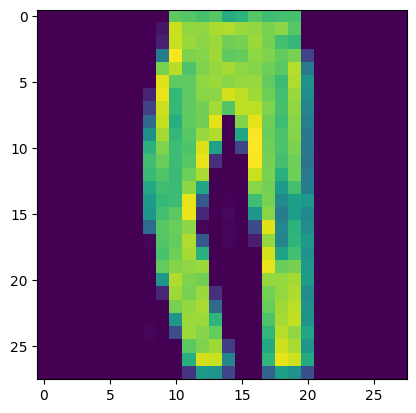

<Figure size 640x480 with 0 Axes>

In [16]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = loaded_model(images)
_, predicted = torch.max(outputs, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(12, 6))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 3, idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(f"Thực tế: {class_names[labels[idx]]}\nDự đoán: {class_names[predicted[idx]]}",
                 color=("green" if predicted[idx] == labels[idx] else "red"))
plt.tight_layout()
plt.show()